In [1]:
# %matplotlib widget

import json
import numpy as np
import scipy
import os.path as op
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from core_functions.simulated_data import simulate
from core_functions.core import em_B

with open(f"{op.expanduser('~')}/.config/sso_config.json", "r") as f:
    config = json.load(f)
basepath = config['basepath']
loadpath = op.join(basepath, 'simdata', 'y_sim.mat')


In [2]:
# Either simulate data or load simulated data
fs = 100

# EM on B
k = 2  # # of oscillators
n = 4  # # of electrodes
M = 3  # # of switching states

A = np.zeros((2 * k, 2 * k, M))
# H = np.zeros((n, 2 * k, M))
Q = np.zeros((2 * k, 2 * k, M))
R = np.zeros((n, n, M))

# Set up for A
osc_freq = np.asarray([7])
rho = 0.90
var_state_noi = 1
var_obs_noi = 1

theta1 = (2 * np.pi * osc_freq[0]) * (1 / fs)
mat1 = np.asarray(
    [[np.cos(theta1), -np.sin(theta1)], [np.sin(theta1), np.cos(theta1)]]
)


for i in range(M):
    A[:, :, i] = scipy.linalg.block_diag(rho * mat1, rho * mat1)
    Q[:, :, i] = var_state_noi*np.eye(2 * k)  # np.cov(noise[:, jumppoint1 + 1:jumppoint2, 1])
    R[:, :, i] = var_obs_noi * np.eye(n)

# B initialization
B0 = np.zeros((n, 2 * k, M))
B0[:, :, 0] = [[0.4, 0, 0, 0], [0, 0, 0.4, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
B0[:, :, 1] = [[0.3, 0, 0, 0], [0, 0.3, 0, 0], [0, 0, 0.25, 0], [0, 0, 0, -0.25]]
B0[:, :, 2] = [[0.5, 0, 0, 0], [-0.5, 0, 0, 0], [0.5, 0, 0, 0], [0, 0, 0.4, 0]]

X_0 = np.random.multivariate_normal(np.zeros(2 * k), np.eye(2 * k)).T
S_0 = 0
Z = np.asarray(
    [[0.998, 0.001, 0.001], [0.001, 0.998, 0.001], [0.001, 0.001, 0.998]]
)


In [3]:
T = 30000
blnSimS = False

ta = np.arange(T)/fs

rng = np.random.default_rng(14)

n = R.shape[0] # # of electrodes
x_dim = A.shape[0] # # of oscillators*2 == k*2 == continuous hidden state dimension
M = A.shape[-1] # # of switching states

if blnSimS:
    s = np.zeros(T,dtype=int)
    s[0] = S_0
else:
    s = np.zeros(T,dtype=int)
    s[ta>80]=1
    s[ta>200]=2
    
x = np.zeros([T,x_dim])
x[0,:] = X_0
y = np.zeros([T,n])
y[0,:] = B0[:,:,S_0]@X_0 + rng.multivariate_normal(np.zeros(n),R[:,:,S_0])
for t in range(1,T):
    if blnSimS:
        s[t] = np.nonzero(rng.multinomial(1,Z[s[t-1],:]))[0][0] # Save the integer in [0,M-1]
    x[t,:] = A[:,:,s[t]]@x[t-1,:] + rng.multivariate_normal(np.zeros(x_dim),Q[:,:,s[t]])
    y[t,:] = B0[:,:,s[t]]@x[t,:] + rng.multivariate_normal(np.zeros(n),R[:,:,s[t]])


In [4]:

# T = 30000
# y, s, x = simulate(A, B0, Q, R, Z, X_0, S_0, T)

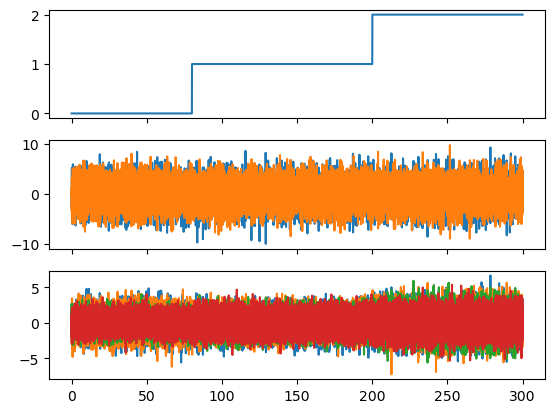

In [5]:
[fig,axs] = plt.subplots(3,1,sharex=True)
axs[0].plot(ta, s)
axs[1].plot(ta, x[:,0],ta,x[:,2])
axs[2].plot(ta, y)

(0.0, 40.0)

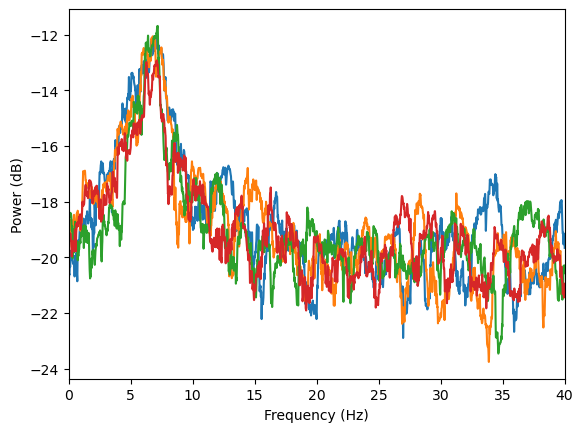

In [6]:
TW=3000
ntapers = 20

m = Multitaper(y,
                sampling_frequency=fs,
                time_halfbandwidth_product=TW,
                n_tapers=20,
                start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
                frequencies=m.frequencies,
                time=m.time)

plt.figure()
plt.plot(c.frequencies, 10*np.log10(c.power().squeeze()))
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,40)


Text(0.5, 1.0, 'Loaded data')

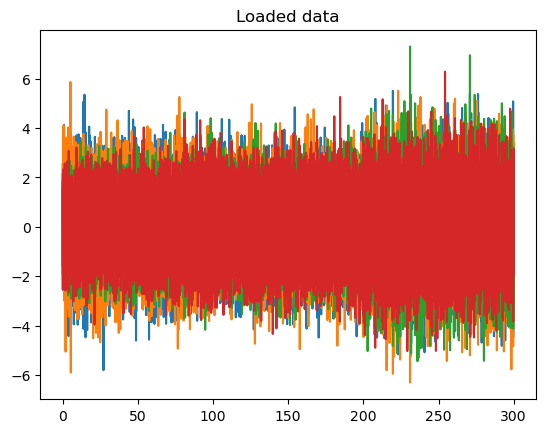

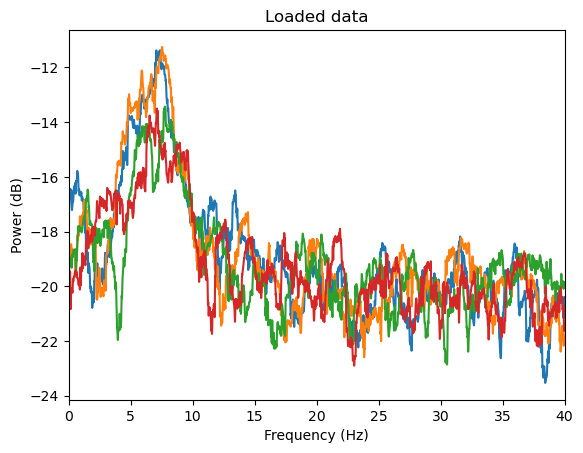

In [7]:
y_load = scipy.io.loadmat(loadpath)['y'].T


plt.figure()
plt.plot(ta, y_load)
plt.title('Loaded data')

m_load = Multitaper(y_load,
                sampling_frequency=fs,
                time_halfbandwidth_product=TW,
                n_tapers=20,
                start_time=ta[0])
c_load = Connectivity(fourier_coefficients=m_load.fft(),
                frequencies=m_load.frequencies,
                time=m_load.time)

plt.figure()
plt.plot(c_load.frequencies, 10*np.log10(c_load.power().squeeze()))
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,40)

plt.title('Loaded data')

In [8]:
def get_theoretical_psd(f_y, Fs, freq_tot, ampl_tot_k, nois_tot_k):
    """
    Returns theoretical/parametric power spectral density (PSD) for a signal generated with Matsuda's et al. (2017) model.
    Based on Hugo Soulat's https://github.com/mh105/SSP/ssp_decomp/get_theoretical_psd.m

    Args:
        f_y (array-like): Frequencies at which PSD is calculated.
        Fs (float): Sampling frequency.
        freq_tot (array-like): Peak frequencies of the oscillators.
        ampl_tot_k (array-like): Amplitudes of the oscillators.
        nois_tot_k (array-like): State noise covariance.

    Returns:
        H_tot (array): Total PSD.
        H_i (array): PSD of a given oscillation at each frequency in freq_tot.

    """

    Nfreq = len(freq_tot)

    # Solve small issue when f_i = Fs / 4 -> w = pi/2
    for ww_i in range(len(freq_tot)):
        if freq_tot[ww_i] == Fs / 4:
            freq_tot[ww_i] = freq_tot[ww_i] + freq_tot[ww_i] * 0.002

    z = np.exp(2j * np.pi * f_y / Fs)
    w_tot = freq_tot * 2 * np.pi / Fs

    nois2 = nois_tot_k

    A_i = (1 - 2 * ampl_tot_k ** 2 * np.cos(w_tot) ** 2 + ampl_tot_k ** 4 * np.cos(2 * w_tot)) / (
            ampl_tot_k * (ampl_tot_k ** 2 - 1) * np.cos(w_tot))
    B_i = 0.5 * (A_i - 2 * ampl_tot_k * np.cos(w_tot) + np.sqrt((A_i - 2 * ampl_tot_k * np.cos(w_tot)) ** 2 - 4))
    V_i = -(nois2 * ampl_tot_k * np.cos(w_tot)) / B_i

    H_i = np.zeros((Nfreq, len(z)))
    for ii in range(Nfreq):
        H_i[ii, :] = (V_i[ii] / Fs) * np.abs(1 + B_i[ii] * z) ** 2 / np.abs(
            1 - 2 * ampl_tot_k[ii] * np.cos(w_tot[ii]) * z + ampl_tot_k[ii] ** 2 * z ** 2) ** 2

    H_tot = np.sum(H_i, axis=0)

    return H_tot, H_i

In [9]:
H_tot, H_i = get_theoretical_psd(c.frequencies, fs, 
                                 np.array([osc_freq[0],osc_freq[0]]), 
                                 np.array([rho,rho]), 
                                 np.array([var_state_noi, var_state_noi]))

# Compute a separate PSD for each electrode and state
nf = len(c.frequencies)
Stheo = np.zeros([nf, n, M]) # freqs x electrodes x states
for i in range(n): # iterate over electrodes
    for m in range(M):
        obsvec = B0[i,:,m]
        for j in range(0,x_dim,2): # Iterate over pairs of state vars
            # sum squared real and imaginary weights, multiply by theo spectrum for that oscillator
            Stheo[:,i,m] += np.sum(obsvec[j:j+2]**2)*H_i[int(j/2),:] 

# Add observation noise
Stheo += var_obs_noi/fs;

# Weighted average over states
S_weights = np.array([np.mean(s==i) for i in range(M)])
Stheo_combined = Stheo@S_weights

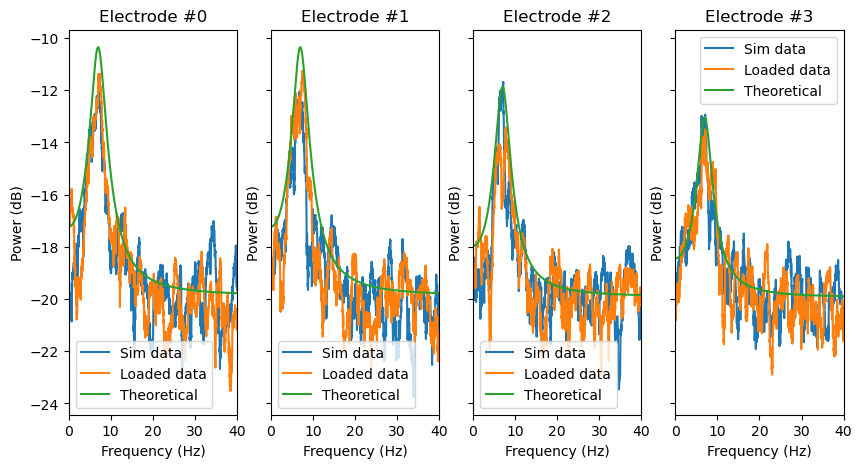

In [10]:
[fig, axs] = plt.subplots(1,n,sharex=True,sharey=True,figsize=[10,5])
for i in range(n):
    axs[i].plot(c.frequencies, 10*np.log10(c.power().squeeze()[:,i]),label='Sim data')
    axs[i].plot(c_load.frequencies, 10*np.log10(c_load.power().squeeze()[:,i]),label='Loaded data')
    axs[i].plot(c.frequencies,10*np.log10(Stheo_combined[:,i]),label='Theoretical')
    axs[i].set_title(f'Electrode #{i}')
    axs[i].set_ylabel('Power (dB)')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].legend()
    axs[i].set_xlim(0,40)

In [11]:


# # Set tolerance and number of iterations
# tol = 1e-6
# max_iter = 10

# em_B(y, tol, max_iter, A, B0, Q, R, Z, X_0)